# Reviewing Learning Curves

### Learning objectives

1. Build and train a Keras Sequential model.
2. Specify various learning rates to a model.
3. Visualize the loss curves.


## Introduction 


In this notebook, you observe learning curve changes. You use the Keras Sequential Model to build an ML model to predict housing prices.

A learning curve is a plot of model learning performance over experience or time.

Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves. Reviewing learning curves of models during training can be used to diagnose problems with learning, such as an underfit or overfit model, as well as whether the training and validation datasets are suitably representative.

Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.


Start by importing the necessary libraries for this lab.

In [1]:
# The OS module in python provides functions for interacting with the operating system
import os
import tensorflow.keras

# The matplotlib module provides all the fuctionalities for visualizing model
import matplotlib.pyplot as plt
# Here we'll import data processing libraries like Pandas and Tensorflow
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import layers
#from keras.optimizers import Adam
#from keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

# Here we'll show the currently installed version of TensorFlow
print("TensorFlow version: ",tf.version.VERSION)

2023-10-25 04:51:42.737678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 04:51:42.916262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-25 04:51:42.916300: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-25 04:51:42.957689: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 04:51:43.932289: W tensorflow/stream_executor/platform/de

TensorFlow version:  2.10.0


Many of the Google Machine Learning Courses Programming Exercises use the  [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description
), which contains data drawn from the 1990 U.S. Census.  Our lab dataset has been pre-processed so that there are no missing values.

First, let's download the raw .csv data by copying the data from a cloud storage bucket.


In [2]:
# Create a directory for storing the dataset
if not os.path.isdir("data"):
    os.makedirs("data")

In [3]:
# The `gsutil cp` command will Copy the file from Google Cloud Storage in the required directory
!gsutil cp gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv data

Copying gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv...
- [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      


Now, let's read in the dataset just copied from the cloud storage bucket and create a Pandas dataframe.

In [5]:
# Reading `housing_pre-proc.csv` file using the read_csv() function included in the pandas library
housing_df = pd.read_csv('data/housing_pre-proc.csv')
# Output the first five rows
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


####  Split the dataset for ML

The dataset we loaded was a single CSV file. We will split this into train, validation, and test sets.


In [7]:
train, test = train_test_split(housing_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

# Let's output the count of `train`, `val` and `test`
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

# The `to_csv()` method will write object to a csv file.
train.to_csv('../data/housing-train.csv', encoding='utf-8', index=False)
val.to_csv('../data/housing-val.csv', encoding='utf-8', index=False)
test.to_csv('../data/housing-test.csv', encoding='utf-8', index=False)

13076 train examples
3270 validation examples
4087 test examples


In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('median_house_value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [10]:
# Next we initialize the training and validation datasets.
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

In [11]:
# Input Pipeline
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']

In [13]:
# Next, we scale the numerical feature columns that we assigned to the variable "numeric cols".
# Scalar def get_scal(feature):
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)


In [14]:
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))


### Using the Keras Sequential Model

Next, we will run this cell to compile and fit the Keras Sequential model.

## Model 1 - hard cording the learning rate to .5

In [15]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

In [16]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

In [17]:
# Model compile
opt = keras.optimizers.Adam(learning_rate=.5)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

In [18]:
# Model Fit
# Using the `fit()` method we can train our model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
409/409 [==============================] - 2s 3ms/step - loss: 14240978944.0000 - mse: 14240978944.0000 - val_loss: 9626010624.0000 - val_mse: 9626010624.0000
Epoch 2/32
409/409 [==============================] - 1s 3ms/step - loss: 10644817920.0000 - mse: 10644817920.0000 - val_loss: 15033883648.0000 - val_mse: 15033883648.0000
Epoch 3/32
409/409 [==============================] - 1s 3ms/step - loss: 10978931712.0000 - mse: 10978931712.0000 - val_loss: 8649022464.0000 - val_mse: 8649022464.0000
Epoch 4/32
409/409 [==============================] - 1s 3ms/step - loss: 10049430528.0000 - mse: 10049430528.0000 - val_loss: 8738983936.0000 - val_mse: 8738983936.0000
Epoch 5/32
409/409 [==============================] - 1s 3ms/step - loss: 8994361344.0000 - mse: 8994361344.0000 - val_loss: 10643721216.0000 - val_mse: 10643721216.0000
Epoch 6/32
409/409 [==============================] - 1s 3ms/step - loss: 8520580608.0000 - mse: 8520580608.0000 - val_loss: 7599363584.0000 - val_m

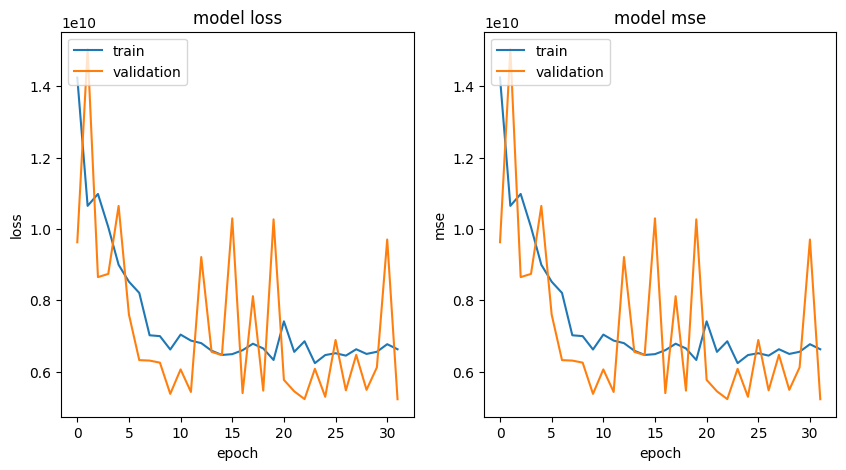

In [19]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
# Using the `figure()` method we can create a new figure or activate an existing figure.
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
# Using the `add_subplot()` method we can add a subplot to the current figure.
        ax = fig.add_subplot(nrows, ncols, idx+1)
# The `plot()` is a versatile function and will take an arbitrary number of arguments. 
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
# Using the `legend()` method we can place a legend on the axes.
        plt.legend(['train', 'validation'], loc='upper left'); 
plot_curves(history, ['loss', 'mse'])

## Model 2 - hard cording the learning rate to .1

In [20]:
# Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
 #TODO 2b
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),
              loss='mse',
              metrics=['mse'])

# Model Fit
# Using the `fit()` method we can train our model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
409/409 [==============================] - 2s 3ms/step - loss: 14571437056.0000 - mse: 14571437056.0000 - val_loss: 10140949504.0000 - val_mse: 10140949504.0000
Epoch 2/32
409/409 [==============================] - 1s 3ms/step - loss: 10440040448.0000 - mse: 10440040448.0000 - val_loss: 12845213696.0000 - val_mse: 12845213696.0000
Epoch 3/32
409/409 [==============================] - 1s 3ms/step - loss: 9014668288.0000 - mse: 9014668288.0000 - val_loss: 7927818752.0000 - val_mse: 7927818752.0000
Epoch 4/32
409/409 [==============================] - 1s 3ms/step - loss: 8331226624.0000 - mse: 8331226624.0000 - val_loss: 9025868800.0000 - val_mse: 9025868800.0000
Epoch 5/32
409/409 [==============================] - 1s 3ms/step - loss: 8166440960.0000 - mse: 8166440960.0000 - val_loss: 13351838720.0000 - val_mse: 13351838720.0000
Epoch 6/32
409/409 [==============================] - 1s 3ms/step - loss: 8266003968.0000 - mse: 8266003968.0000 - val_loss: 7460239360.0000 - val_mse

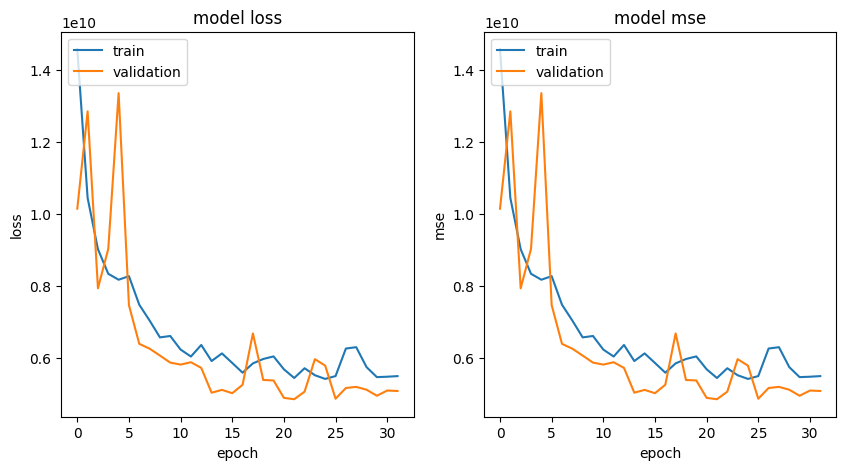

In [21]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
# Using the `figure()` method we can create a new figure or activate an existing figure.
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
# Using the `add_subplot()` method we can add a subplot to the current figure.
        ax = fig.add_subplot(nrows, ncols, idx+1)
# The `plot()` is a versatile function and will take an arbitrary number of arguments. 
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
# Using the `legend()` method we can place a legend on the axes.
        plt.legend(['train', 'validation'], loc='upper left');  
plot_curves(history, ['loss', 'mse'])

## Model 3 - hard cording the learning rate to .01 

In [22]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
 #TODO 2c
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

# Model Fit
# Using the `fit()` method we can train our model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)  # Increase Epochs to 32

Epoch 1/32
409/409 [==============================] - 2s 3ms/step - loss: 30297782272.0000 - mse: 30297782272.0000 - val_loss: 22377842688.0000 - val_mse: 22377842688.0000
Epoch 2/32
409/409 [==============================] - 1s 3ms/step - loss: 15223715840.0000 - mse: 15223715840.0000 - val_loss: 11167416320.0000 - val_mse: 11167416320.0000
Epoch 3/32
409/409 [==============================] - 1s 3ms/step - loss: 11166861312.0000 - mse: 11166861312.0000 - val_loss: 10692452352.0000 - val_mse: 10692452352.0000
Epoch 4/32
409/409 [==============================] - 1s 3ms/step - loss: 10750628864.0000 - mse: 10750628864.0000 - val_loss: 10330346496.0000 - val_mse: 10330346496.0000
Epoch 5/32
409/409 [==============================] - 1s 3ms/step - loss: 10363685888.0000 - mse: 10363685888.0000 - val_loss: 10033550336.0000 - val_mse: 10033550336.0000
Epoch 6/32
409/409 [==============================] - 1s 3ms/step - loss: 10012057600.0000 - mse: 10012057600.0000 - val_loss: 10104424448.0

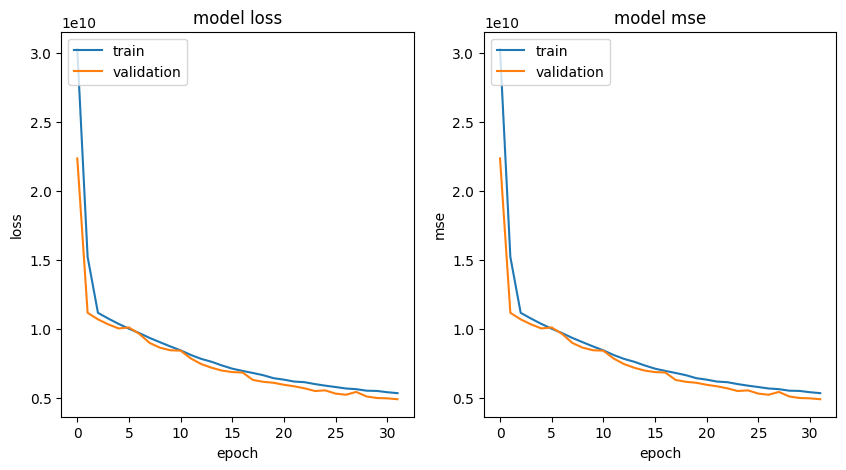

In [23]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
# Using the `figure()` method we can create a new figure or activate an existing figure.
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
# Using the `add_subplot()` method we can add a subplot to the current figure.
        ax = fig.add_subplot(nrows, ncols, idx+1)
# The `plot()` is a versatile function and will take an arbitrary number of arguments. 
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
# Using the `legend()` method we can place a legend on the axes.
        plt.legend(['train', 'validation'], loc='upper left');  
plot_curves(history, ['loss', 'mse'])

## Model 4 - hard cording the learning rate to .001 

In [24]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
 #TODO 2d
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

# Model Fit
# Using the `fit()` method we can train our model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)  # Increase Epochs to 32

Epoch 1/32
409/409 [==============================] - 2s 3ms/step - loss: 45875101696.0000 - mse: 45875101696.0000 - val_loss: 30238410752.0000 - val_mse: 30238410752.0000
Epoch 2/32
409/409 [==============================] - 1s 3ms/step - loss: 27388157952.0000 - mse: 27388157952.0000 - val_loss: 26963836928.0000 - val_mse: 26963836928.0000
Epoch 3/32
409/409 [==============================] - 1s 3ms/step - loss: 26493628416.0000 - mse: 26493628416.0000 - val_loss: 26276593664.0000 - val_mse: 26276593664.0000
Epoch 4/32
409/409 [==============================] - 1s 3ms/step - loss: 25773725696.0000 - mse: 25773725696.0000 - val_loss: 25473796096.0000 - val_mse: 25473796096.0000
Epoch 5/32
409/409 [==============================] - 1s 3ms/step - loss: 24884043776.0000 - mse: 24884043776.0000 - val_loss: 24471996416.0000 - val_mse: 24471996416.0000
Epoch 6/32
409/409 [==============================] - 1s 3ms/step - loss: 23800543232.0000 - mse: 23800543232.0000 - val_loss: 23279605760.0

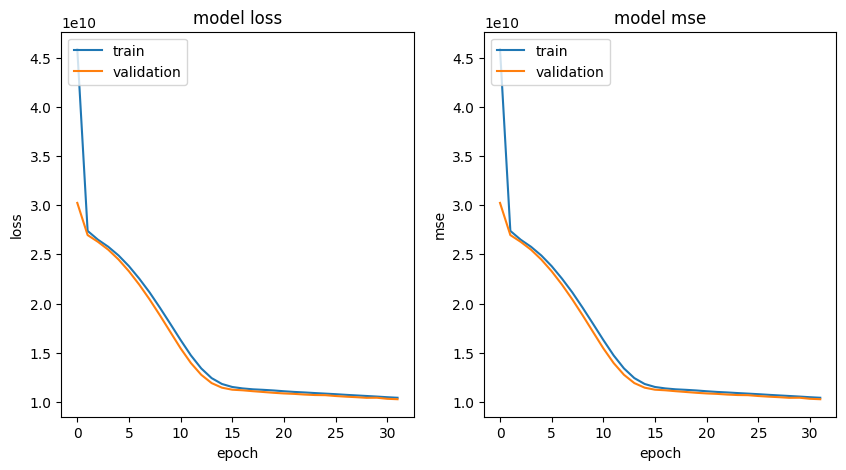

In [25]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
# Using the `figure()` method we can create a new figure or activate an existing figure.
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
# Using the `add_subplot()` method we can add a subplot to the current figure.
        ax = fig.add_subplot(nrows, ncols, idx+1)
# The `plot()` is a versatile function and will take an arbitrary number of arguments. 
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
# Using the `legend()` method we can place a legend on the axes.
        plt.legend(['train', 'validation'], loc='upper left');  
        
plot_curves(history, ['loss', 'mse'])